In [27]:
import pandas as pd
from top2vec import Top2Vec
import top2vec
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import umap

In [2]:
# 1. load the data

df = pd.read_csv("../data/sample_100k_v2.csv")
documents = df["Description"].dropna().astype(str).tolist()

In [6]:
print(len(documents))

99968


## Top2vec model

We used top2vec to cluster the description column of almost 100k records. It returns xxx topics. After raising the min_count to 300, be default it's set to be 50, the number of topic goes down to 501, which is still a lot.

In [3]:
# 2. Using Top2Vec Model to show the number of topic
model = Top2Vec(documents, embedding_model='doc2vec', 
                speed='learn', workers=4, min_count=300)
print(f"Number of topics found: {model.get_num_topics()}")


2025-05-13 00:48:17,240 - top2vec - INFO - Pre-processing documents for training
2025-05-13 00:48:34,486 - top2vec - INFO - Creating joint document/word embedding
2025-05-13 00:55:37,296 - top2vec - INFO - Creating lower dimension embedding of documents
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-13 00:57:13,889 - top2vec - INFO - Finding dense areas of documents
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-13 00:57:23,212 - top2vec - INFO

Number of topics found: 501


In [21]:
topic_sizes, topic_nums = model.get_topic_sizes()

top_n = 10
sorted_idx = np.argsort(topic_sizes)[::-1]
top_topic_nums = [topic_nums[i] for i in sorted_idx[:top_n]]

topics_words, word_scores, topic_ids = model.get_topics()

# Print 10 most popular topics
for i in range(len(topic_ids)):
    if topic_ids[i] in top_topic_nums:
        print(f"\n🔥 Topic #{topic_ids[i]} ({topic_sizes[topic_nums.tolist().index(topic_ids[i])]} docs)")
        for word, score in zip(topics_words[i][:10], word_scores[i][:10]):
            print(f"  {word:15s}  (score: {score:.4f})")


🔥 Topic #0 (4368 docs)
  shipping         (score: 0.5288)
  faster           (score: 0.5267)
  better           (score: 0.4862)
  service          (score: 0.4752)
  fpo              (score: 0.2392)
  customer         (score: 0.1959)
  multiple         (score: 0.1903)
  depending        (score: 0.1687)
  orders           (score: 0.1621)
  satisfaction     (score: 0.1619)

🔥 Topic #1 (3777 docs)
  murder           (score: 0.5792)
  her              (score: 0.5630)
  she              (score: 0.5576)
  finds            (score: 0.5457)
  herself          (score: 0.5404)
  him              (score: 0.5384)
  dangerous        (score: 0.5363)
  killer           (score: 0.5348)
  mysterious       (score: 0.5301)
  seems            (score: 0.5210)

🔥 Topic #2 (2572 docs)
  smartbuyglasses  (score: 0.8392)
  curve            (score: 0.8387)
  harmful          (score: 0.8337)
  shield           (score: 0.8334)
  staying          (score: 0.8301)
  rays             (score: 0.8278)
  frames          

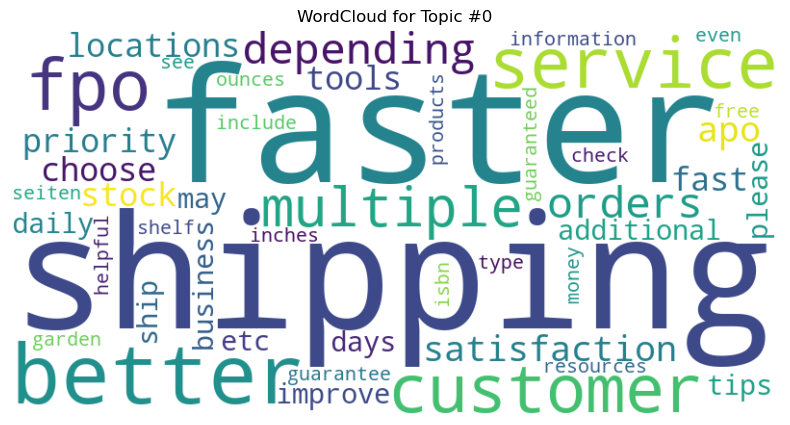

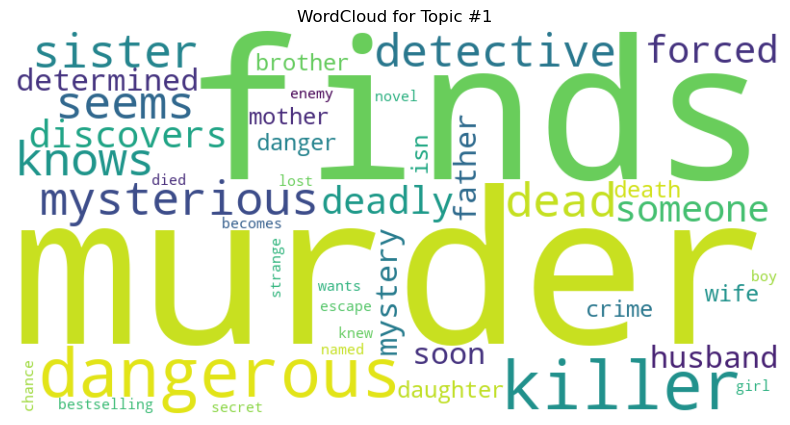

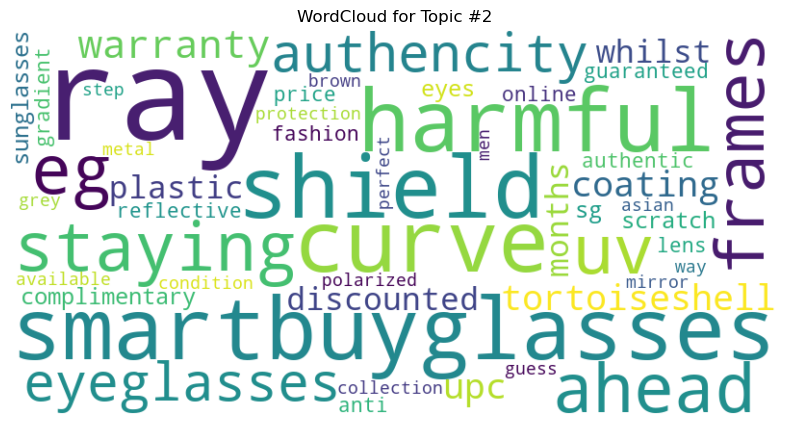

In [24]:
topics_words, _, topic_nums = model.get_topics()

for i in range(3):  
    text = " ".join(topics_words[i])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Topic #{topic_nums[i]}")
    plt.show()

## Reduce the topics

In [43]:
def get_reduced_topic_keywords(model, hierarchy, topn=10):
    """
    Aggregate representative keywords for reduced topics using Top2Vec's hierarchical_topic_reduction.

    Parameters:
        model (Top2Vec): A trained Top2Vec model.
        hierarchy (List[List[int]]): Output of model.hierarchical_topic_reduction(num_topics=...).
        topn (int): Number of most common keywords to return per reduced topic.

    Returns:
        dict: Mapping of reduced topic index to list of top representative keywords.
    """
    # Get original topics (full top 50 words per topic)
    topics_words, word_scores, topic_nums = model.get_topics()

    # Map topic_num to its corresponding words
    topic_id_to_words = {tid: words for tid, words in zip(topic_nums, topics_words)}

    reduced_topic_keywords = {}

    # Merge original topic keywords according to hierarchy
    for new_topic_id, original_topic_ids in enumerate(hierarchy):
        words = []
        for topic_id in original_topic_ids:
            words.extend(topic_id_to_words[topic_id])
        from collections import Counter
        most_common = [word for word, _ in Counter(words).most_common(topn)]
        reduced_topic_keywords[new_topic_id] = most_common

    return reduced_topic_keywords


In [ ]:
hierarchy = model.hierarchical_topic_reduction(num_topics=50)

In [36]:
reduced_keywords = get_reduced_topic_keywords(model, hierarchy, topn=10)

for topic_id, keywords in reduced_keywords.items():
    print(f"Reduced Topic {topic_id}: {', '.join(keywords)}")

Reducing topics: 100%|███████████████████████████████████████████████████████████████| 451/451 [06:17<00:00,  1.19it/s]


Reduced Topic 0: father, him, she, her, sister, knows, herself, forced, someone, died
Reduced Topic 1: shipping, faster, better, service, fpo, customer, multiple, depending, orders, satisfaction
Reduced Topic 2: sleeves, button, pockets, wash, fastenings, tumble, bleach, multipockets, unlined, dry
Reduced Topic 3: silhouette, effortlessly, chic, effortless, sleek, look, stylish, versatile, wardrobe, dress
Reduced Topic 4: wisdom, relationships, financial, successful, success, business, strategy, leadership, behavior, church
Reduced Topic 5: textbook, concise, handbook, comprehensive, systems, exam, methods, thorough, clinical, assessment
Reduced Topic 6: codes, highlighting, orders, may, markings, intact, shelf, shipping, cds, used
Reduced Topic 7: nineteenth, history, europe, historian, centuries, century, war, period, historians, account
Reduced Topic 8: hem, cotton, relaxed, ribbed, flattering, tee, blend, sweater, stylish, versatile
Reduced Topic 9: shield, price, warranty, frames,

In [37]:
def get_reduced_topic_vectors(model, hierarchy):
    """
    Compute reduced topic vectors by averaging original topic vectors in each group.

    Parameters:
        model (Top2Vec): A trained Top2Vec model.
        hierarchy (List[List[int]]): Output from model.hierarchical_topic_reduction()

    Returns:
        List[np.ndarray]: List of averaged topic vectors for each reduced topic.
    """
    # Get original topic vectors and their topic numbers
    topic_vectors = model.topic_vectors
    _, _, topic_nums = model.get_topics()
    topic_id_to_vector = {tid: vec for tid, vec in zip(topic_nums, topic_vectors)}

    # Compute averaged vectors for each reduced topic
    reduced_vectors = []
    for group in hierarchy:
        group_vectors = [topic_id_to_vector[tid] for tid in group]
        avg_vector = np.mean(group_vectors, axis=0)
        reduced_vectors.append(avg_vector)

    return reduced_vectors

C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


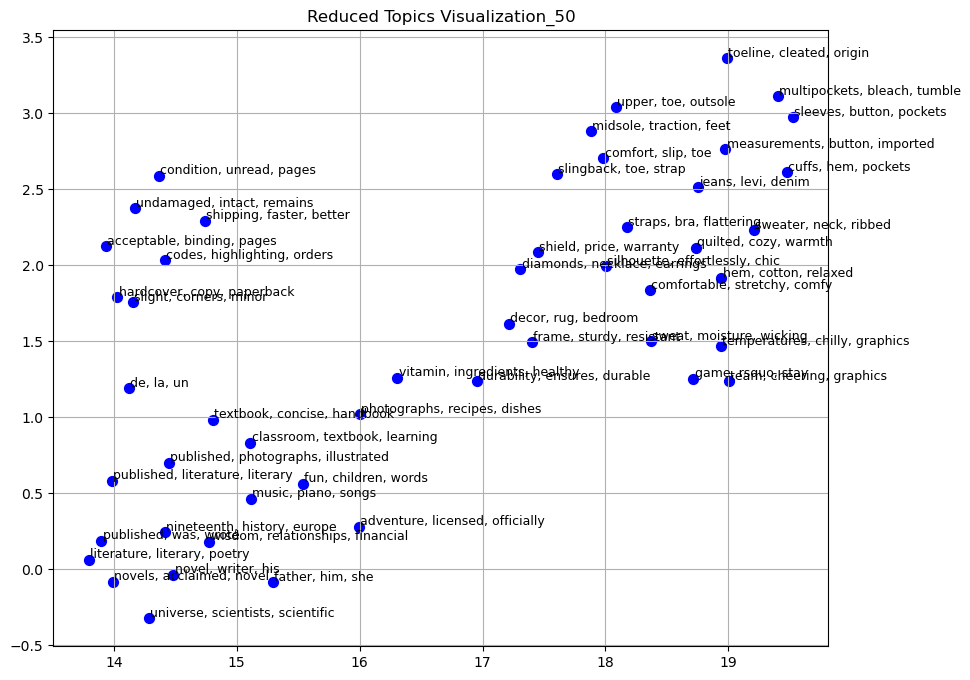

In [49]:
# Step 1: Reduce topics

reduced_vectors = get_reduced_topic_vectors(model, hierarchy)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(reduced_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', s=50)
for i, (x, y) in enumerate(embedding):
    label = ", ".join(reduced_keywords[i][:3])  # show top 3 words
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)
plt.title("Reduced Topics Visualization_50")
plt.grid(True)
plt.show()

C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


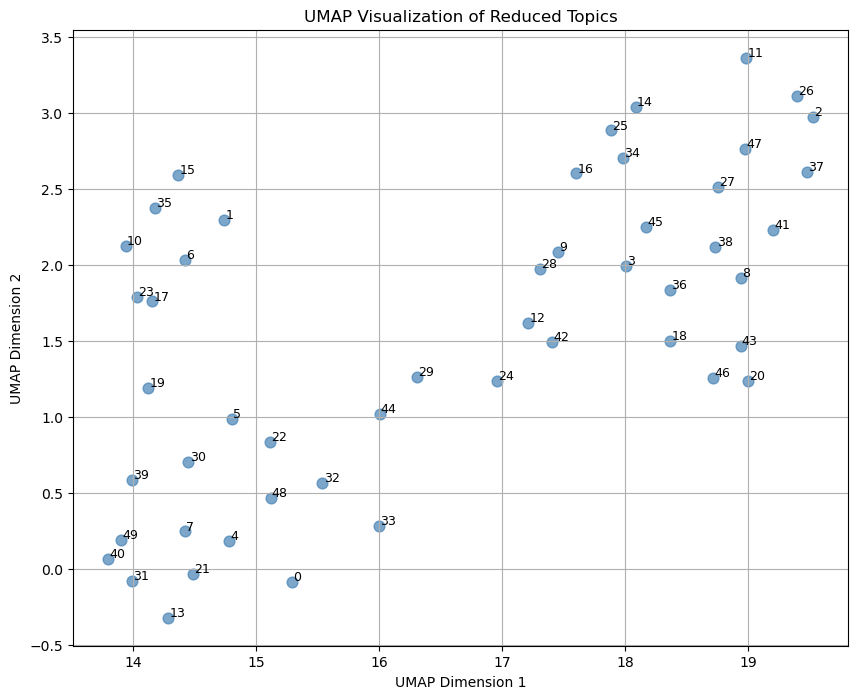

In [40]:
# Step 3: UMAP to 2D
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(reduced_vectors)

# Step 4: Plot
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='steelblue', s=60, alpha=0.7)

# Optionally label each reduced topic
for i, (x, y) in enumerate(embedding):
    plt.text(x + 0.01, y + 0.01, f"{i}", fontsize=9)

plt.title("UMAP Visualization of Reduced Topics")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()

## Reduced topics to 100

In [41]:
hierarchy_100 = model.hierarchical_topic_reduction(num_topics=100)

Reducing topics: 100%|███████████████████████████████████████████████████████████████| 401/401 [05:41<00:00,  1.17it/s]


C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


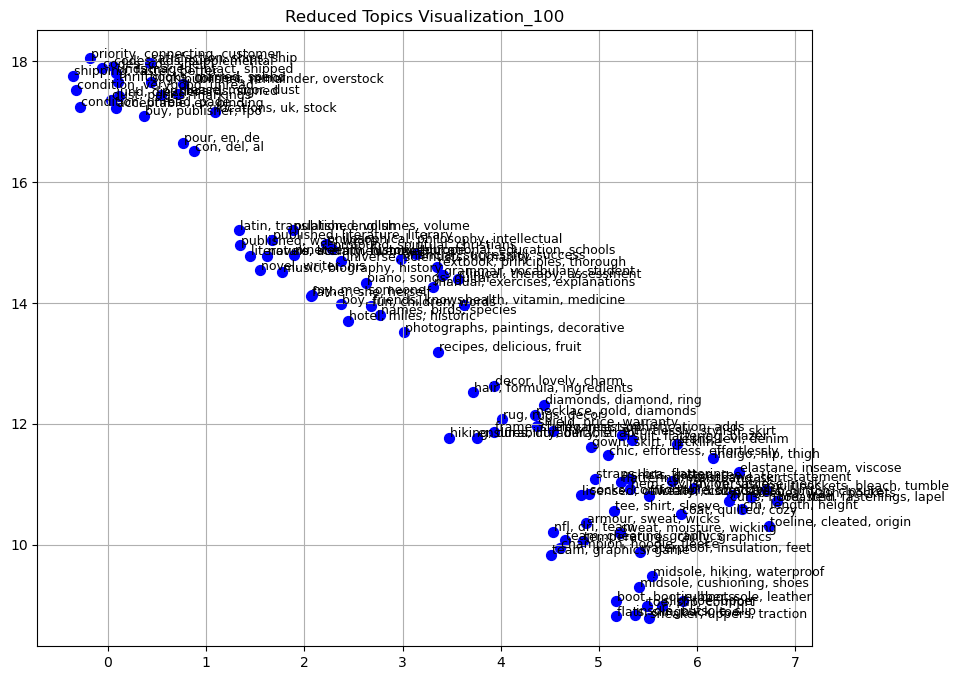

In [45]:
reduced_keywords_100 = get_reduced_topic_keywords(model, hierarchy_100, topn=10)

reduced_vectors_100 = get_reduced_topic_vectors(model, hierarchy_100)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(reduced_vectors_100)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', s=50)
for i, (x, y) in enumerate(embedding):
    label = ", ".join(reduced_keywords_100[i][:3])  # show top 3 words
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)
plt.title("Reduced Topics Visualization_100")
plt.grid(True)
plt.show()


## Reduced topics to 30

In [46]:
hierarchy_30 = model.hierarchical_topic_reduction(num_topics=30)

Reducing topics: 100%|███████████████████████████████████████████████████████████████| 471/471 [06:15<00:00,  1.25it/s]


C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


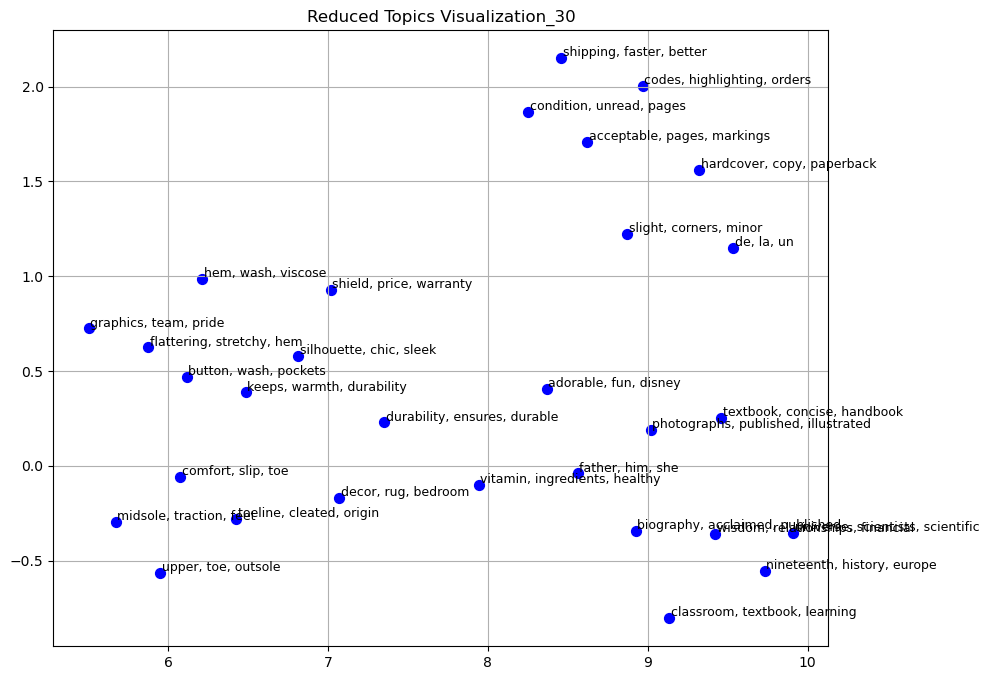

In [48]:
reduced_keywords_30 = get_reduced_topic_keywords(model, hierarchy_30, topn=10)

reduced_vectors_30 = get_reduced_topic_vectors(model, hierarchy_30)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(reduced_vectors_30)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', s=50)
for i, (x, y) in enumerate(embedding):
    label = ", ".join(reduced_keywords_30[i][:3])  # show top 3 words
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)
plt.title("Reduced Topics Visualization_30")
plt.grid(True)
plt.show()